# Solution for Dropped Tarots

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
!curl https://storage.googleapis.com/aiolympiadmy_public/maio_2025_dropped_tarots/dropped_tarots.npy -o dropped_tarots.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3037k  100 3037k    0     0  4563k      0 --:--:-- --:--:-- --:--:-- 4560k


In [3]:
X = np.load("dropped_tarots.npy")

In [4]:
def visualize_pointcloud(pointcloud, elev=30, azim=30):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extract spatial and color data
    x = pointcloud[:, 0]
    y = pointcloud[:, 1]
    z = pointcloud[:, 2]
    colors = pointcloud[:, 3:6]

    scatter = ax.scatter(x, y, z, c=colors, s=2)

    # Set axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set view angle
    ax.view_init(elev=elev, azim=azim)

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()

Let's first put some effort into visualizing to see what we are working with:

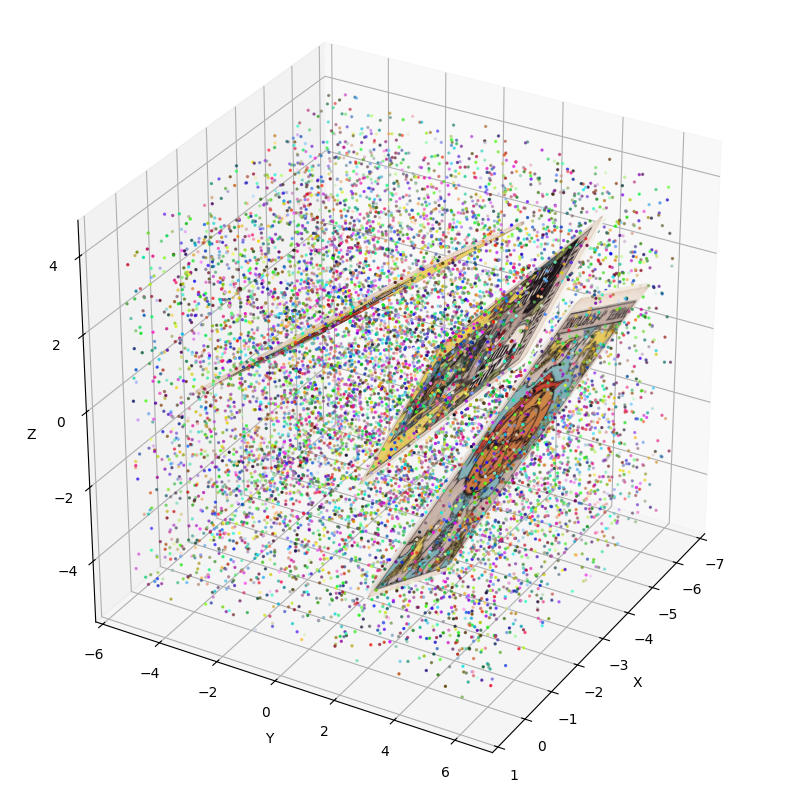

In [5]:
visualize_pointcloud(X, elev=30, azim=30)

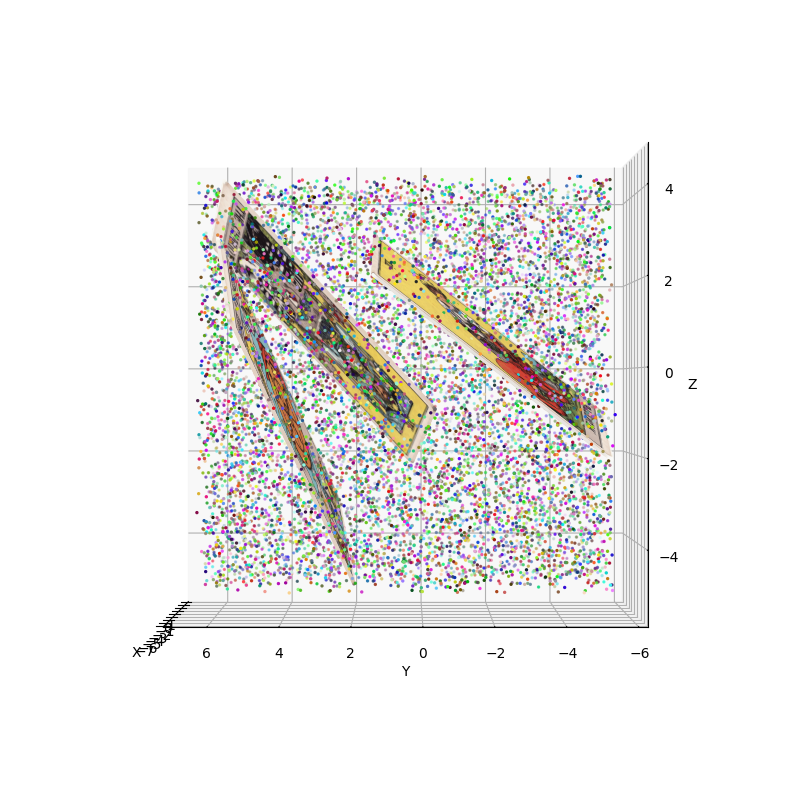

In [6]:
visualize_pointcloud(X, elev=0, azim=180)

There are three tarot cards in a 3D volume with many noisy points. Some of the cards are very close to each other. We shoud be able to separate the cards with some clsutering as long as we handle them carefully.

Since the points representing the card are not distributed about a sphere, let us go with DBSCAN here instead of something like k-means clustering.

(18070, 3)
(18076, 3)
(18063, 3)


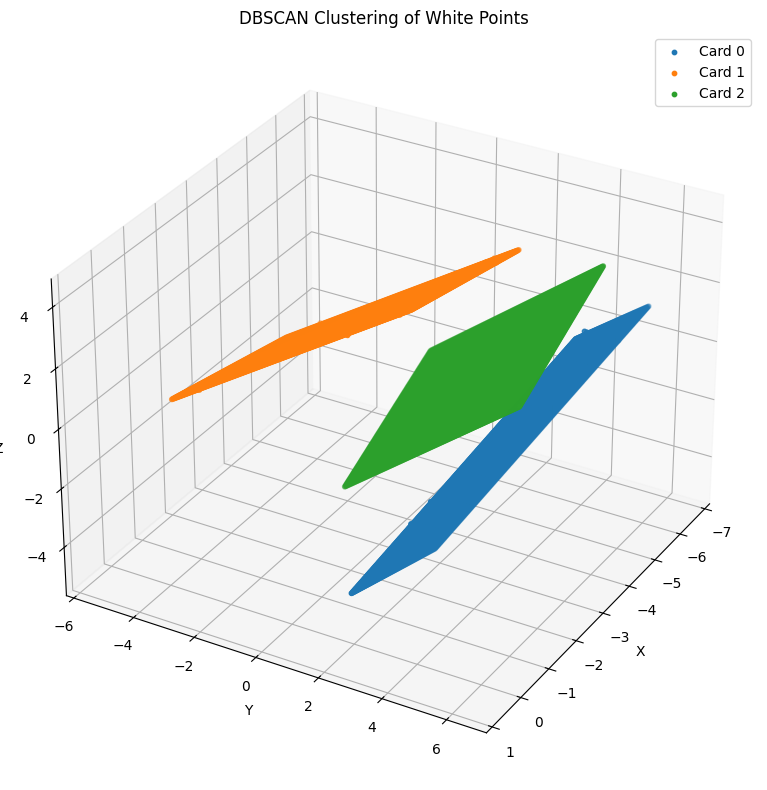

In [7]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

points = X[:, :3]
colors = X[:, 3:]

# Step 2: Cluster using DBSCAN
dbscan = DBSCAN(eps=0.08, min_samples=5)  # Tune eps and min_samples
labels = dbscan.fit_predict(points)

# Step 3: Visualize clustering
unique_labels = np.unique(labels)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    if label == -1:
        continue  # Skip noise
    cluster_points = points[labels == label]
    print(cluster_points.shape)
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], s=10, label=f'Card {label}')

ax.set_title("DBSCAN Clustering of White Points")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set view angle
ax.view_init(elev=30, azim=30)
ax.legend()
plt.tight_layout()
plt.show()

We managed to remove most of the noise and isolate each card, albeit some noise do remain.

In [8]:
from sklearn.linear_model import RANSACRegressor
import numpy as np
import os

def filter_near_plane(points, colors, threshold=0.005):
    # Fit plane: z = a*x + b*y + c
    X = points[:, :2]  # x, y
    y = points[:, 2]   # z

    ransac = RANSACRegressor(residual_threshold=threshold)
    ransac.fit(X, y)

    z_pred = ransac.predict(X)
    residuals = np.abs(z_pred - y)

    mask = residuals < threshold
    return points[mask], colors[mask]

Cluster 0: 18000 kept from 18070 points


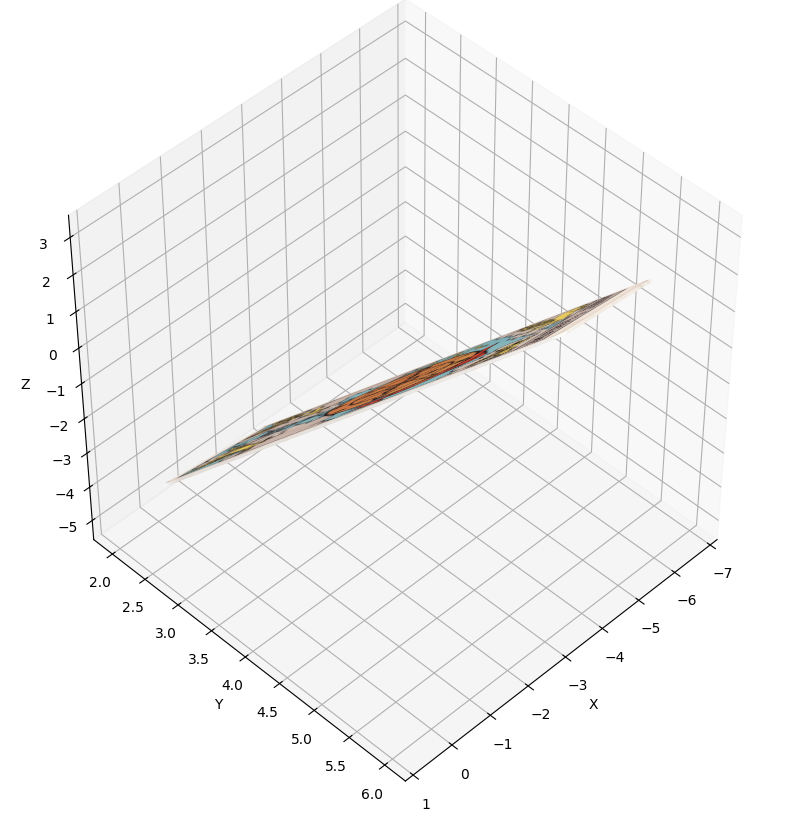

Cluster 1: 18000 kept from 18076 points


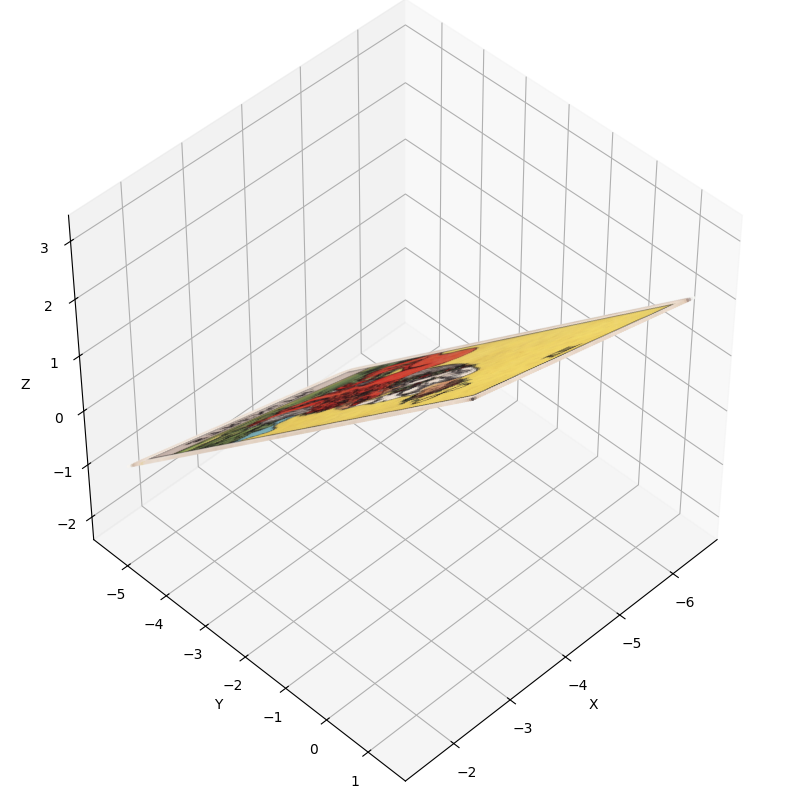

Cluster 2: 18000 kept from 18063 points


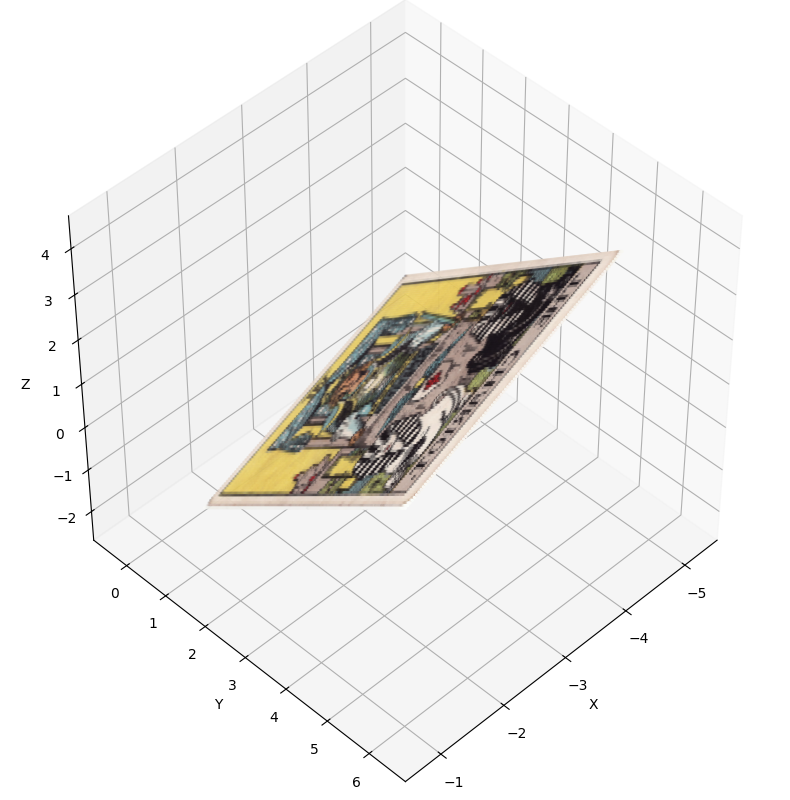

In [9]:
cluster_pointclouds = []

unique_labels = np.unique(labels)

for label in unique_labels:
    if label == -1:
        continue
    cluster_points = points[labels == label]
    cluster_colors = colors[labels == label]

    filtered_points, filtered_colors = filter_near_plane(cluster_points, cluster_colors, threshold=0.0008)
    cluster_pointcloud = np.hstack((filtered_points, filtered_colors))

    print(f"Cluster {label}: {len(filtered_points)} kept from {len(cluster_points)} points")
    visualize_pointcloud(cluster_pointcloud, elev=45, azim=45)

    cluster_pointclouds.append(cluster_pointcloud)

Extracting the card from 3D volume into its own flat 2D image:

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def extract_card(pointcloud, angle):
    # PCA fit to align with principal axes
    pca = PCA(n_components=3)
    pca.fit(pointcloud[:, :3])
    points_pca = pca.transform(pointcloud[:, :3])
    
    # Grab top two principal components, 3rd should be blank!
    xy = points_pca[:, :2]
    
    # Center it for rotation
    xy_centered = xy - xy.mean(axis=0)
    
    # Apply rotation
    theta = np.deg2rad(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_corrected = xy_centered @ rotation_matrix.T
    
    # points, rgb, pca
    return xy_corrected, pointcloud[:, 3:], pca

In [12]:
card1, rgb1, pca1 = extract_card(cluster_pointclouds[0], angle=270)
card2, rgb2, pca2 = extract_card(cluster_pointclouds[1], angle=90)
card3, rgb3, pca3 = extract_card(cluster_pointclouds[2], angle=270)

In [13]:
card1.shape, rgb1.shape

((18000, 2), (18000, 3))

`card1` is the coordinates, `rgb` is the colors.

In [14]:
card1[:, 0].min(), card1[:, 0].max()

(np.float64(-2.0000000000000537), np.float64(2.000000000000053))

In [15]:
card1[:, 1].min(), card1[:, 1].max()

(np.float64(-4.0000000000000275), np.float64(4.000000000000028))

Appears that the cards have x=-2 to 2, and y=-4 to 4

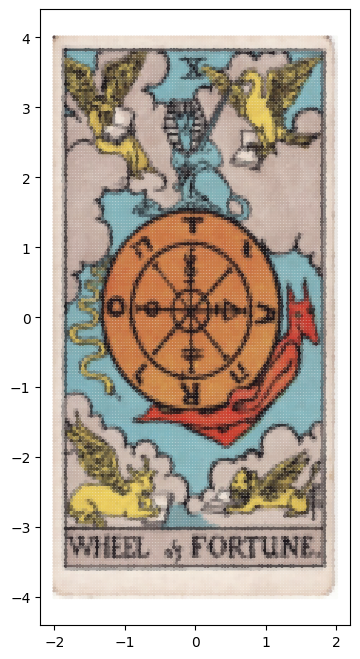

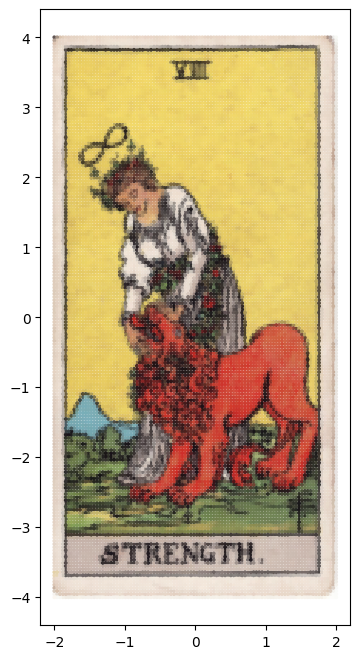

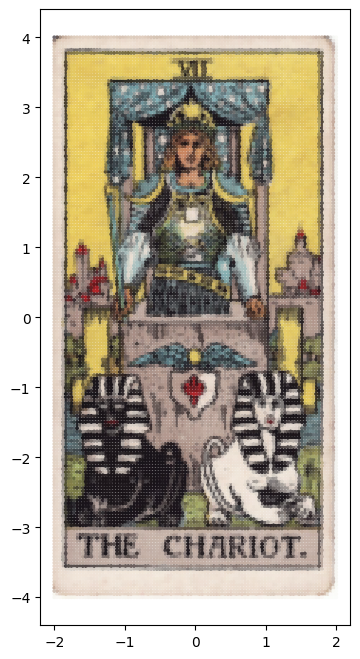

In [16]:
plt.figure(figsize=(4, 8))
plt.scatter(card1[:, 0], card1[:, 1], c=rgb1, s=3)
plt.show()

plt.figure(figsize=(4, 8))
plt.scatter(card2[:, 0], card2[:, 1], c=rgb2, s=3)
plt.show()

plt.figure(figsize=(4, 8))
plt.scatter(card3[:, 0], card3[:, 1], c=rgb3, s=3)
plt.show()

Transforming back into 3D points:

In [17]:
def reconstruct_from_saved(points, rgb, pca, angle):
    # Reverse rotation using negative angle
    theta = np.deg2rad(-angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = points @ rotation_matrix.T
    
    # Restore the third dim of all zeros to plug back into PCA
    xyz_pca = np.hstack([xy_rotated, np.zeros((len(xy_rotated), 1))])
    points_3d = pca.inverse_transform(xyz_pca)
    
    return np.hstack([points_3d, rgb])

In [18]:
recon1 = reconstruct_from_saved(card1, rgb1, pca1, 270)
recon2 = reconstruct_from_saved(card2, rgb2, pca2, 90)
recon3 = reconstruct_from_saved(card3, rgb3, pca3, 270)

In [19]:
recon1.shape

(18000, 6)

In [20]:
all_tensors = np.concatenate([recon1, recon2, recon3], axis=0)

In [21]:
all_tensors.shape

(54000, 6)

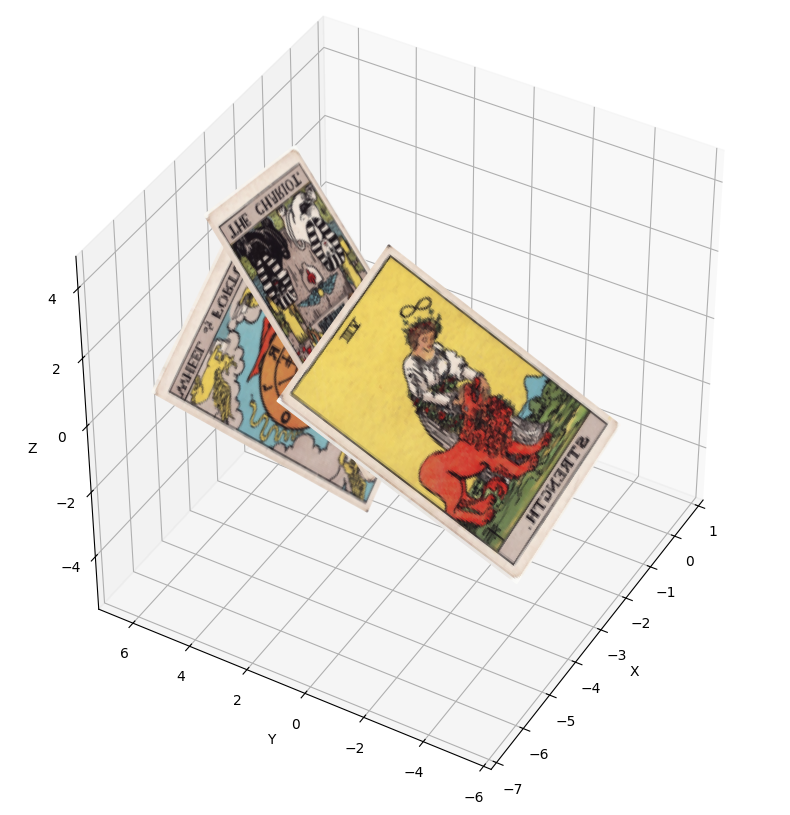

In [22]:
visualize_pointcloud(all_tensors, elev=40, azim=210)

## Alternate solution

What makes a tarot card? Realize that each point in the tarot card has at least one neighbor in the x direction and one neighbor in the y direction that has the same distance as all the other points on the tarot card.

![](https://storage.googleapis.com/aiolympiadmy_public/maio_2025_dropped_tarots/xy_grid.png)

Therefore, we can loop over each point and its k-nearest neighbors, and check if fulfills the above condition.

In [23]:
X_dist = X[:, :3] # extract coordinates, shape (64800, 3)
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 10 # number of closest point

# Returns the k nearest neighbors for each points, we remove index 0 because closest neighbor is self.
nbrs = NearestNeighbors(n_neighbors = k + 1, algorithm='auto').fit(X_dist)
distances, _ = nbrs.kneighbors(X_dist) 
distances = distances[:, 1:] # shape (64800, 10)

print(distances[:10, :])

[[0.04040404 0.04040404 0.04469274 0.04469274 0.06024888 0.06024888
  0.06024888 0.06024888 0.08080808 0.08080808]
 [0.04040404 0.04040404 0.04469274 0.04469274 0.06024888 0.06024888
  0.06024888 0.06024888 0.08080808 0.08080808]
 [0.04040404 0.04040404 0.04469274 0.04469274 0.06024888 0.06024888
  0.06024888 0.06024888 0.07505491 0.08080808]
 [0.04040404 0.04040404 0.04469274 0.04469274 0.06024888 0.06024888
  0.06024888 0.06024888 0.08080808 0.08080808]
 [0.04040404 0.04040404 0.04469274 0.04469274 0.06024888 0.06024888
  0.06024888 0.06024888 0.08080808 0.08080808]
 [0.04040404 0.04040404 0.04469274 0.04469274 0.06024888 0.06024888
  0.06024888 0.06024888 0.08080808 0.08080808]
 [0.04040404 0.04040404 0.04469274 0.04469274 0.06024888 0.06024888
  0.06024888 0.06024888 0.08080808 0.08080808]
 [0.04040404 0.04040404 0.04469274 0.06024888 0.06024888 0.08080808
  0.08080808 0.08938547 0.09234385 0.09234385]
 [0.04040404 0.04040404 0.04469274 0.04469274 0.06024888 0.06024888
  0.06024888

In [24]:
answer = []
for index, distance_array in enumerate(distances):
    count = 0

    for distance in distance_array:
    # some tolerance for float comparison
        if distance <= 0.04040405 and distance >= 0.04040403: 
            count += 1
	
	# accept both 1 or 2 because edges only have 1 horizontal/vertical neighbor
    if count == 1 or count == 2:
        answer.append(index)

print(len(answer))

54000


In [25]:
filtered_X = X[answer]
filtered_X.shape

(54000, 6)

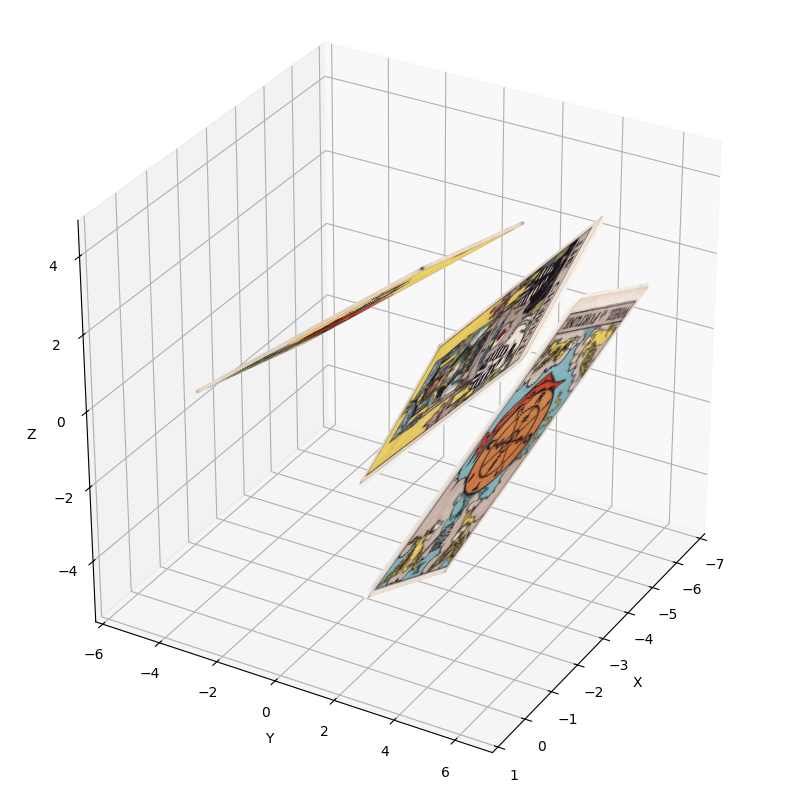

In [26]:
visualize_pointcloud(filtered_X)

Since this is noise free, a simple DBSCAN will separate the cards.

In [29]:
color = filtered_X[:, 3:6]
filtered_X = filtered_X[:, :3] # keep only coordinates for visualization

In [30]:
from sklearn.cluster import DBSCAN

print(filtered_X.shape)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(filtered_X)
group = dbscan.labels_
print(np.unique(group, return_counts=True))

card_1 = filtered_X[group == 0]
card_2 = filtered_X[group == 1]
card_3 = filtered_X[group == 2]
card_1_color = color[group == 0]
card_2_color = color[group == 1]
card_3_color = color[group == 2]

(54000, 3)
(array([0, 1, 2]), array([18000, 18000, 18000]))
